# Embedding graphs in Minkowski spacetime

> The views of space and time which I wish to lay before you have sprung from the soil of experimental physics, and therein lies their strength. They are radical. Henceforth space by itself, and time by itself, are doomed to fade away into mere shadows, and only a kind of union of the two will preserve an independent reality. — Hermann Minkowski, 1908

![title](lightcone.svg.png)

#### **Implementation of Lorentzian graph embeddings:**

**[1]** Clough JR, Evans TS (2017) Embedding graphs in Lorentzian spacetime. PLoS ONE 12(11):e0187301. https://doi.org/10.1371/journal.pone.0187301<br>

The authors also released their own open-source Python library that can be found here: https://github.com/JamesClough/dagology

**Two Main Steps:**<br>
- Given some input DAG, we compute a pairwise dissimilarity matrix by estimating space-like and time-like separations. <br>
- Apply generalized Lorentzian MDS with this separation matrix


Given only pairwise separations $M_{ij}$, can we recover coordinates in Lorentzian spacetime which respect these separations?

 Therefore we seek to assign coordinates to the nodes such that
those pairs connected by some directed path are timelike separated, while the remaining
unconnected pairs are spacelike separate

**DAG Embedding Algorithm:**<br>
1. For every pair $i$ and $j$ connected by a directed path, find length of the longest directed path between them, $L_{i j}$
2. For every other pair, find the naive spacelike distance $N_{i j}$ .
3. Create separation matrix, M, such that $M_{i j}$ = $-L_{i j}^{2}$ if there is a path from $i$ to $j$ and
$N_{i j}^{2}$ otherwise.
4. Use Lorentzian MDS with $\mathrm{M}$ as the input matrix of squared separations.

## Ex.) Estimating Minkowski separation for Causal set graph

In [2]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
# plotting style
%matplotlib inline
plt.style.use('seaborn')
# display multiple outputs within a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all";
# ignore warnings
import warnings
warnings.filterwarnings('ignore');

Minkowski distance/separation between pair i,j: $$M_{i j}=M\left(\mathbf{x}_{i}, \mathbf{x}_{j}\right)=-c^{2}\left(x_{i}^{0}-x_{j}^{0}\right)^{2}+\sum_{k=1}^{d}\left(x_{i}^{k}-x_{j}^{k}\right)^{2}$$
If $M_{ij} < 0:$ time-like separated (can be causally connected)<br>
If $M_{ij} > 0:$ space-like separated (NOT causally connected)<br>
If $M_{ij} = 0:$ light-like separated (on the light-cone boundary)

In [211]:
def minkowski_dist(x, y, c=1):
    """Minkowski separation between x and y, c = speed of light parameter"""
    d0 = -c**2 * (x[0] - y[0])**2
    d1 = np.sum((x[1:] - y[1:])**2)
    return d0 + d1

def minkowski_interval(N, D):
    R = np.random.random((N, D))
    a = np.concatenate(([0], np.zeros(D-1)+0.5))
    b = np.concatenate(([1], np.zeros(D-1)+0.5))
    R[0] = a
    R[1] = b
    for i in range(2, N):
        while (minkowski_dist(a, R[i, :]) > 0) or ((minkowski_dist(R[i, :], b) > 0)):
            R[i, :] = np.random.random(D)
    return R

def causal_set_graph(n, d=2):
    X = minkowski_interval(n, d)
    G = nx.DiGraph()
    n = X.shape[0]
    for i in range(n):
        G.add_node(i, position=X[i])
        for j in range(i, n):
            if minkowski_dist(X[i], X[j]) < 0:
                if X[i][0] < X[j][0]:
                    G.add_edge(i, j)
                else:
                    G.add_edge(j, i)
    return G

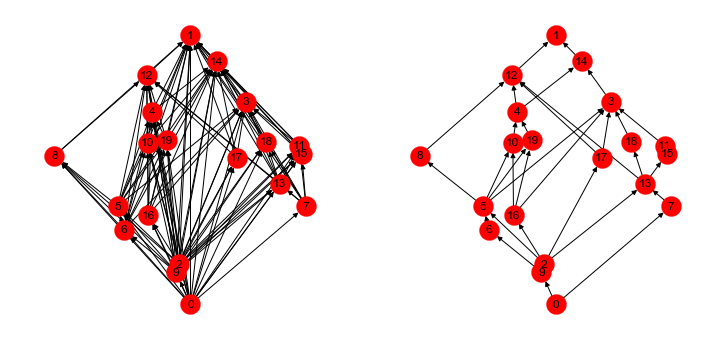

In [232]:
N = 20
G = causal_set_graph(N, 2)
options = {'node_size': 400,
           'width': 1,
           'with_labels': True}
draw_pos = {i:G.node[i]['position'][::-1] for i in range(N)}
trans_G = nx.transitive_reduction(G)
plt.figure(figsize=(12, 6))
plt.subplot(121)
nx.draw(G, pos=draw_pos, **options)
plt.subplot(122)
nx.draw(trans_G, pos=draw_pos, **options);

In [233]:
# longest path distance between s, t
def longest_path(G, s, t):
    if s!= t and nx.has_path(G, source=s, target=t):
        path_lengths = []
        for path in nx.all_simple_paths(G, source=s, target=t):
            path_lengths.append(len(path))
        return max(path_lengths)
    else:
        return 0

# get longest path lengths for all time-separated nodes
def longest_paths(G):
    n = len(list(G.nodes()))
    M = np.empty((n, n))
    for i in range(n):
        for j in range(n):
            M[i][j] = -longest_path(G, i, j)**2
    return M

In [234]:
# get naive spacelike distances if no path i --> j
def naive_spatial_distances(L, G):
    M = L.copy()
    n = L.shape[0]
    max_dist = np.max(np.abs(L))
    for i in range(n):
        for j in range(n):
            if  L[i,j] == 0 and (i != j):
                past_i = nx.ancestors(G, i)
                past_j = nx.ancestors(G, j)
                common_past = list(past_i.intersection(past_j))
                future_i = nx.descendants(G, i)
                future_j = nx.descendants(G, j)
                common_future = list(future_i.intersection(future_j))
                naive_dists = []
                if (len(common_past) > 0) and (len(common_future) > 0):
                    for k in common_past:
                        for l in common_future:
                            if nx.has_path(G, source=k, target=l):
                                naive_dists.append(longest_path(G, k, l))
                            else:
                                naive_dists.append(max_dist)
                    M[i,j] = np.min(naive_dists)**2
                else:
                    M[i,j] = max_dist
    return M

In [237]:
def LorentzMDS(M, d):
    """Performs Classical Multidimensional Scaling
    Parameters
    ----------
    M : Minkowski separation matrix (n x n)
    d: Dimension of the output configuration
    
    Returns
    -------
    X : Matrix with columns as the output embedding vectors (d x n)
    """
    # get shape of distance matrix                                                                         
    n = M.shape[0]
    
    # centering matrix
    C = np.identity(n) -(1/n)*np.ones((n,n))
    
    # compute gram matrix                                                                                    
    B = -(1/2)*C.dot(M).dot(C)
    
    # solve for eigenvectors and eigenvalues and sort descending                                                   
    w, v = np.linalg.eigh(B)                                                  
    idx = np.argsort(w)[::-1]
    eigvals = w[idx]
    eigvecs = v[:,idx]
    # select k largest eigenvalues and eigenvectors                      
    S  = np.diag(np.concatenate((np.sqrt(-1*eigvals[-1:]), np.sqrt(eigvals[:d-1]))))
    U  = np.hstack((eigvecs[:,-1:], eigvecs[:,:d-1]))
    X  = np.dot(S, np.transpose(U))
    X = np.transpose(X)
    return X

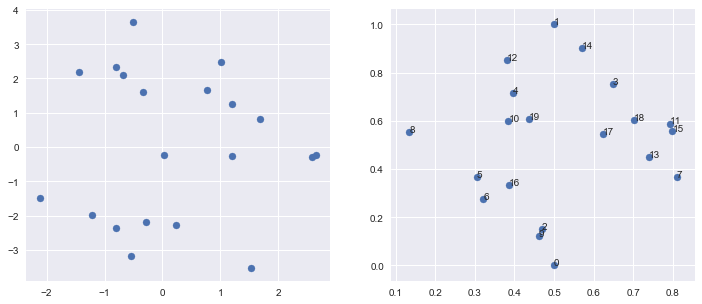

In [243]:
M = naive_spatial_distances(longest_paths(G), G)
X = LorentzMDS(M, 2)
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1])
plt.subplot(122)
X_orig = np.array([G.node[i]['position'][::-1] for i in range(N)])
plt.scatter(X_orig[:, 0], X_orig[:, 1])
for i in range(N):
    _ = plt.text(X_orig[i, 0], X_orig[i, 1], str(i));
plt.show();